In [30]:
# === 0) Imports necesarios ===

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
warnings.filterwarnings("ignore")

In [31]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod.csv", sep=";", decimal=".", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y") #Convertir la columna 'date' a formato datetime
df = df.set_index("date") #Establecer la columna 'date' como índice 
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y

In [32]:
# === 2) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0:
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()

In [33]:
# === 3) Preparar las variables exógenas ===

# cols_exog = ["Sol", "Precipitación", "Temperatura", "Festivos", "Agosto", "ICC", "Covid", "Tendencia"]
cols_exog = [ "Sol", "Precipitación", "Temperatura", "Festivos", "Agosto", "ICC", "Covid", "Tendencia"]

# Sustituir comas por puntos y convertir a float
for c in cols_exog:
    df[c] = df[c].astype(str)
    df[c] = df[c].str.replace(",", ".", regex=False)
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Verifica los tipos
print(df[cols_exog].dtypes)
X_full = df[cols_exog]  # DataFrame con las variables exógenas

# 2. División 80/20
division_idx = int(len(y_masked) * 0.80)

# 3. División en entrenamiento y prueba
X_train = X_full.iloc[:division_idx]
X_test  = X_full.iloc[division_idx:]
y_train = y_masked.iloc[:division_idx]
y_test  = y_masked.iloc[division_idx:]

Sol              float64
Precipitación    float64
Temperatura      float64
Festivos           int64
Agosto             int64
ICC              float64
Covid            float64
Tendencia          int64
dtype: object


In [34]:
# === 4) Optimización de las variables P,D,Q y p,d,q ===

p = d = q = range(0, 2) # Valores posibles para p, d, q del 0 al 1   
P = D = Q = range(0, 2) # Valores posibles para p, d, q del 0 al 1
m = 12 

resultados=[]

# Combinaciones de parámetros SARIMA
# Se generan todas las combinaciones posibles de (p,d,q,P,D,Q) para SARIMA
# Se usa itertools.product para generar el producto cartesiano de los rangos definidos
for comb in itertools.product(p, d, q, P, D, Q):
    try:
        model = SARIMAX(y, order=(comb[0], comb[1], comb[2]),
                           seasonal_order=(comb[3], comb[4], comb[5], m),
                           enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        resultados.append((res.aic, comb))
    except:
        continue


best_aic, best_tuple = min(resultados, key=lambda t: t[0]) # Obtener la combinación con el AIC más bajo
p_best, d_best, q_best, P_best, D_best, Q_best = best_tuple # Desempaquetar la mejor combinación de parámetros

resultados.sort(key=lambda x: x[0]) # Ordenar resultados por AIC
print("Mejores combinaciones (AIC bajo):") # Imprimir las 5 mejores combinaciones

# Mostrar las 5 mejores combinaciones de parámetros con sus respectivos AIC
for aic, comb in resultados[:5]:
    print(f"AIC={aic:.1f} → (p,d,q,P,D,Q)={comb}")
print(f"\nMejor combinación encontrada: AIC={best_aic:.1f} → (p,d,q,P,D,Q)=({p_best},{d_best},{q_best},{P_best},{D_best},{Q_best})")

Mejores combinaciones (AIC bajo):
AIC=1708.9 → (p,d,q,P,D,Q)=(0, 1, 1, 1, 1, 1)
AIC=1709.2 → (p,d,q,P,D,Q)=(0, 1, 1, 0, 1, 1)
AIC=1710.1 → (p,d,q,P,D,Q)=(1, 1, 1, 0, 1, 1)
AIC=1722.5 → (p,d,q,P,D,Q)=(1, 1, 1, 1, 1, 1)
AIC=1724.9 → (p,d,q,P,D,Q)=(1, 0, 1, 0, 1, 1)

Mejor combinación encontrada: AIC=1708.9 → (p,d,q,P,D,Q)=(0,1,1,1,1,1)


In [35]:
# === 5) Entrenamiento del modelo ===

# Modelo con los mejores parámetros encontrados
modelo = SARIMAX(
    endog=y_train,           # tu variable dependiente
    exog=X_train,            # tus variables exógenas
    order=(p_best, d_best, q_best),
    seasonal_order=(P_best, D_best, Q_best, m),
    enforce_stationarity=True,
    enforce_invertibility=True
)

# Modelo con los mejores parámetros encontrados automáticamente
# modelo = SARIMAX(datos_entreno, order=(p_best, d_best, q_best), seasonal_order=(P_best, D_best, Q_best, m),
#               enforce_stationarity=True, enforce_invertibility=True)

modelo_entrenado = modelo.fit() # Entrenamiento del modelo

In [36]:
# === 6) Predicciones del modelo ===

h = len(X_test) # Horizonte de predicción igual al tamaño del conjunto de prueba
future_exog = X_test  # Las variables exógenas para el periodo de prueba

predicciones_modelo = modelo_entrenado.get_forecast(steps=h, exog=future_exog) # Predicciones futuras 
predicciones = predicciones_modelo.predicted_mean # Valores predichos
pred_intervalo_confianza = predicciones_modelo.conf_int() # Intervalo de confianza de las predicciones

#Preparación de los datos para la evaluación del modelo
eval_df = pd.concat(
    [y_test.rename("y_true").astype(float), predicciones.rename("y_pred").astype(float)],
    axis=1
).dropna()

# Asignación de los valores verdaderos y predichos
y_verd = eval_df["y_true"].values
y_pred = eval_df["y_pred"].values


In [37]:
# === 7) Cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }

# Cálculo y presentación de las métricas
metrics = metricas(y_verd, y_pred, eps_mape=1.0)

# Impresión de las métricas
for k, v in metrics.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

R2: 0.65
RMSLE: 0.51
RMSE: 1,625.66
MAE: 1,374.51
MAPE_safe(%): 42.40%
SMAPE(%): 35.76%
WAPE(%): 25.58%


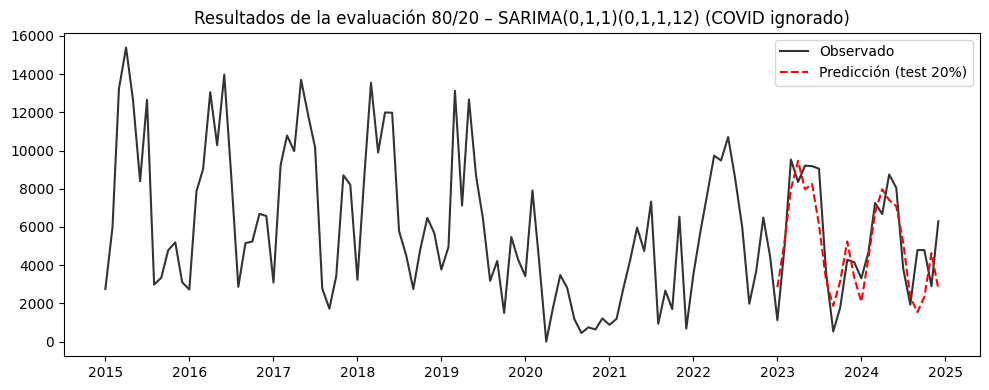

In [38]:
# === 8) Gráfico evaluación entrenamiento  ===

# Gráfico evaluación
plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones.index, predicciones, "--", label="Predicción (test 20%)", color="red")
plt.title("Resultados de la evaluación 80/20 – SARIMA(0,1,1)(0,1,1,12) (COVID ignorado)")
plt.legend(); plt.tight_layout(); plt.show()

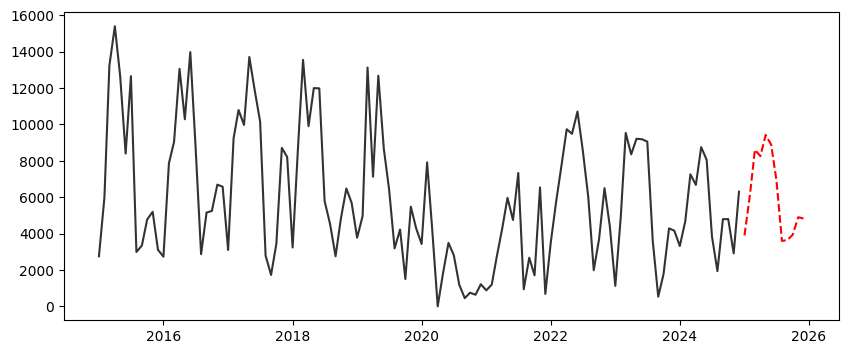

In [39]:
# === 9) Gráfico predicción  ===

# Predicciones futuras a 12 meses
pred_fut = res.get_forecast(steps=12) # Predicciones a 12 meses
predicciones_futuras = pred_fut.predicted_mean # Valores predichos

# Graficar la predicción
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones_futuras.index, predicciones_futuras, "--", label="Forecast +12m", color="red")

In [40]:
# === 10) Función completa de entrenamiento y  con variantes para encontrar el mejor modelo ===

def entreno_variantes(y, order=(p_best,q_best,d_best), seas=(P_best,Q_best,D_best,m), split_ratio=0.8, horizon=12,X=None, X_future=None):

    # División en train/test
    s = int(len(y) * split_ratio)
    train, test = y.iloc[:s], y.iloc[s:]

    # Prepara X_train y X_test si hay X
    if X is not None:
        X = (X.reindex(y.index)
               .replace([np.inf, -np.inf], np.nan)
               .fillna(method="ffill").fillna(method="bfill"))
        X_train, X_test = X.iloc[:s].copy(), X.iloc[s:].copy()
    else:
        X_train = X_test = None


    variants = {}

    # A) base (sin drift)
    resA = SARIMAX(train, exog=X_train, order=order, seasonal_order=seas, trend="n",
                   enforce_stationarity=True, enforce_invertibility=True).fit(disp=False) # Entrenamiento del modelo
    predA = resA.get_forecast(steps=len(test), exog=X_test).predicted_mean # Predicción
    variants["base"] = metricas(test, predA) # Evaluación

    # B) drift
    resB = SARIMAX(train, exog=X_train, order=order, seasonal_order=seas, trend="c", #
                   enforce_stationarity=True, enforce_invertibility=True).fit(disp=False) # Entrenamiento del modelo #
    predB = resB.get_forecast(steps=len(test), exog=X_test).predicted_mean # Predicción
    variants["drift"] = metricas(test, predB) # Evaluación

    # C) log1p + bias fix
    tr_log = np.log1p(np.maximum(train, 0))
    resC = SARIMAX(tr_log, exog=X_train, order=order, seasonal_order=seas, trend="c",
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False) # Entrenamiento del modelo
    prC = resC.get_forecast(steps=len(test), exog=X_test) # Predicción
    mu, var = prC.predicted_mean, prC.var_pred_mean #  Predicción
    predC = pd.Series(np.exp(mu + 0.5*var) - 1.0, index=mu.index) # Ajuste por sesgo
    variants["log1p_biasfix"] = metricas(test, predC) # Evaluación

    # D) Rolling refit 1-step (validación)
    preds_roll, idx = [], []
    # Bucle de predicción paso a paso con reentrenamiento
    for t in range(s, len(y)):
        ytr = y.iloc[:t]
        Xtr = X.iloc[:t] if X is not None else None
        res = SARIMAX(ytr, exog=Xtr, order=order, seasonal_order=seas, trend="c",
                      enforce_stationarity=True, enforce_invertibility=True).fit(disp=False) # Reentrenamiento del modelo
        x_next = X.iloc[t:t+1] if X is not None else None # Siguiente exógena
        preds_roll.append(res.get_forecast(steps=1, exog=x_next).predicted_mean.iloc[0]) # Predicción del siguiente paso
        idx.append(y.index[t]) # Guardar el índice correspondiente
    pred_roll = pd.Series(preds_roll, index=idx) # Predicciones acumuladas
    variants["rolling_refit_1step"] = metricas(y.iloc[s:], pred_roll) # Evaluación

    # Ranking y ganador
    df_result = (pd.DataFrame([{"Variante": k, **v} for k, v in variants.items()])
                 .sort_values("WAPE(%)").reset_index(drop=True))
    winner = df_result.loc[0, "Variante"]

    # Prepara X_future si hay X
    if X is not None:
        if X_future is None:
            # fallback: repetir última fila de X
            try:
                freq = y.index.freq or pd.infer_freq(y.index) # Inferir la frecuencia del índice de y
                fut_idx = pd.date_range(y.index[-1], periods=horizon+1, freq=freq)[1:] # Generar índice futuro
            except Exception:
                fut_idx = pd.RangeIndex(start=len(y), stop=len(y)+horizon, step=1) # Índice entero como fallback
            X_future = pd.DataFrame([X.iloc[-1].values]*horizon, columns=X.columns, index=fut_idx) # Repetir última fila
        else:
            X_future = (X_future.reindex(columns=X.columns) # Asegura mismas columnas
                                  .replace([np.inf, -np.inf], np.nan) # Reemplaza infinitos por NaN
                                  .fillna(method="ffill").fillna(method="bfill")) # Rellenar NaN
    # Forecast final con todo y
    #   Modelo ganador si es "base", "drift", "log1p_biasfix" o "rolling_refit_1step" que reentrena paso a paso
    if winner == "base":
        resa = SARIMAX(y, exog=X, order=order, seasonal_order=seas, trend="n",
                       enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
        fc = resa.get_forecast(steps=horizon, exog=X_future if X is not None else None).predicted_mean

    elif winner == "drift":
        resa = SARIMAX(y, exog=X, order=order, seasonal_order=seas, trend="c",
                       enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
        fc = resa.get_forecast(steps=horizon, exog=X_future if X is not None else None).predicted_mean

    elif winner == "log1p_biasfix":
        ylog = np.log1p(np.maximum(y, 0))
        resa = SARIMAX(ylog, exog=X, order=order, seasonal_order=seas, trend="c",
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pr = resa.get_forecast(steps=horizon, exog=X_future if X is not None else None)
        mu, var = pr.predicted_mean, pr.var_pred_mean
        fc = pd.Series(np.exp(mu + 0.5*var) - 1.0, index=mu.index)
    # El ganador es rolling_refit_1step
    else:

        try:
            freq = y.index.freq or pd.infer_freq(y.index)
            fut_idx = pd.date_range(y.index[-1], periods=horizon+1, freq=freq)[1:]
        except Exception:
            fut_idx = pd.RangeIndex(start=len(y), stop=len(y)+horizon, step=1)

        preds_roll = []
        # Bucle de predicción paso a paso con reentrenamiento
        for h in range(horizon):
            # y de entrenamiento en cada paso: toda y + lo ya pronosticado
            if h == 0:
                ytr = y
            else:
                ytr = pd.concat([y, pd.Series(preds_roll, index=fut_idx[:h])])

            # exógenas hasta el paso actual (si hay)
            if X is not None:
                Xtr = pd.concat([X, X_future.iloc[:h]]) if h > 0 else X
                x_next = X_future.iloc[h:h+1]
            else:
                Xtr = None
                x_next = None
            # Reentrenamiento del modelo
            res = SARIMAX(ytr, exog=Xtr, order=order, seasonal_order=seas, trend="c",
                          enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
            next_pred = res.get_forecast(steps=1, exog=x_next).predicted_mean.iloc[0]
            preds_roll.append(next_pred)
        # Predicciones acumuladas
        fc = pd.Series(preds_roll, index=fut_idx)

    return df_result, winner, fc

# Ejecución de la función con los datos enmascarados y las mejores combinaciones encontradas
df_result, winner, prediccion12 = entreno_variantes(
    y_masked,                                
    order=(p_best, d_best, q_best),          
    seas=(P_best, D_best, Q_best, m),        
    split_ratio=0.80,
    horizon=12,
    X=X_full,                              
    X_future=None                            
)

# Presentación de resultados y predicciones
print(df_result)
print("Predicción 12 mes:\n", prediccion12)


              Variante        R2     RMSLE         RMSE          MAE  \
0                 base  0.647170  0.510569  1625.657525  1374.506338   
1  rolling_refit_1step  0.363192  1.790197  2183.989156  1816.698306   
2                drift -0.065432  3.100449  2824.937549  2154.038916   
3        log1p_biasfix -0.198687  0.645382  2996.394026  2548.605503   

   MAPE_safe(%)   SMAPE(%)    WAPE(%)  
0     42.397323  35.757384  25.583714  
1     48.450127  44.504713  33.814242  
2     49.687336  67.271242  40.093169  
3     81.767366  46.079835  47.437245  
Predicción 12 mes:
 2025-01-01    2368.343769
2025-02-01    5477.146913
2025-03-01    5651.334847
2025-04-01    2973.224646
2025-05-01    5222.776803
2025-06-01    3452.910487
2025-07-01   -1389.208302
2025-08-01   -5341.461161
2025-09-01   -3654.683154
2025-10-01   -2996.160825
2025-11-01     109.068608
2025-12-01    5153.133808
Freq: MS, Name: predicted_mean, dtype: float64


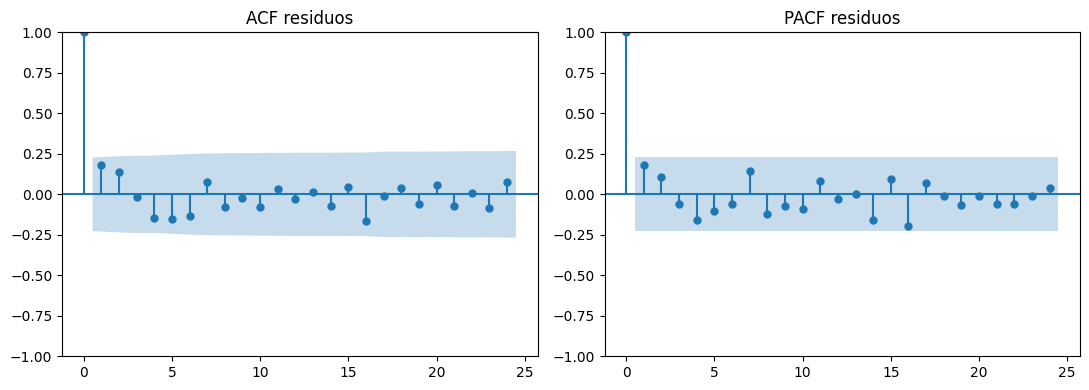

      lb_stat  lb_pvalue
12  10.874347   0.539717
24  16.940604   0.851184
Durbin–Watson: 1.6364033989573659
ARCH test: (np.float64(13.784677821005381), np.float64(0.18304161340933395), 1.4549103596489412, 0.18281432851283894)


In [41]:
# === 11) Análisis de residuos del modelo óptimo ===

order = (p_best, d_best, q_best)
seasonal_order = (P_best, D_best, Q_best, m)

# Entrenamiento del modelo óptimo con todas las observaciones de entrenamiento
# Trend = "n" sin drift, con "c" con drift
modelo_optimo = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order, trend="n",
                   enforce_stationarity=True, enforce_invertibility=True)
modelo_optimo_entrenado = modelo_optimo.fit(disp=False)

 #  Predicciones del modelo óptimo
predicciones_futuras_optimas = modelo_optimo_entrenado.get_forecast(steps=h, exog=future_exog) # Predicciones futuras
valores_predicciones_optimas = predicciones_futuras_optimas.predicted_mean # Valores predichos
intervalo_confianza_optimo = predicciones_futuras_optimas.conf_int() # Intervalo de confianza de las predicciones

# Análisis de residuos
resid = pd.Series(modelo_optimo_entrenado.resid, index=y_train.index).dropna()

# Gráficos ACF y PACF de los residuos
fig, ax = plt.subplots(1, 2, figsize=(11,4))
plot_acf(resid, lags=24, ax=ax[0])
plot_pacf(resid, lags=24, ax=ax[1])
ax[0].set_title("ACF residuos")
ax[1].set_title("PACF residuos")
plt.tight_layout()
plt.show()

# Prueba de Ljung-Box para autocorrelación
print(sm.stats.acorr_ljungbox(resid, lags=[12,24], return_df=True))
# Durbin–Watson y ARCH test
print("Durbin–Watson:", durbin_watson(resid))
print("ARCH test:", het_arch(resid))

Cobertura del intervalo 95% en test: 100.0%


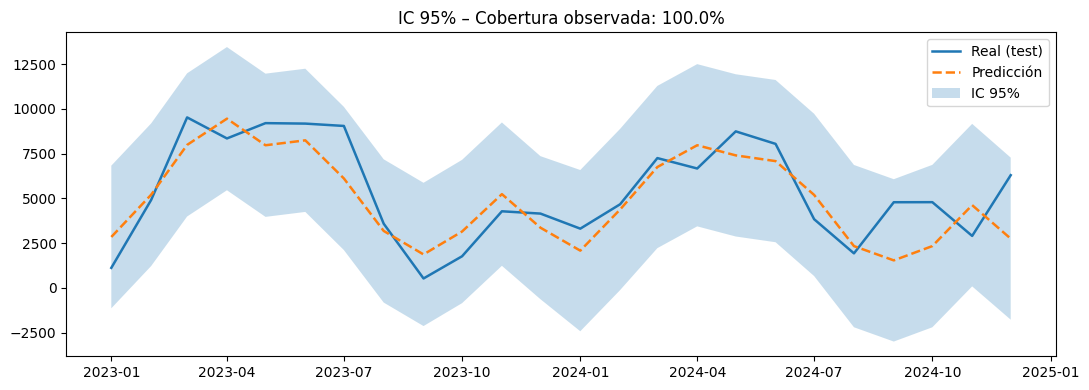

In [42]:
# === 12) Cobertura del intervalo de confianza al 95% ===

# Cálculo de la cobertura del intervalo de confianza al 95%
df_cov = pd.concat(
    [y_test.rename("y"), valores_predicciones_optimas.rename("yhat"), intervalo_confianza_optimo.iloc[:,0].rename("lo"), intervalo_confianza_optimo.iloc[:,1].rename("hi")],
    axis=1
).dropna()
coverage = float(((df_cov["y"] >= df_cov["lo"]) & (df_cov["y"] <= df_cov["hi"])).mean() * 100)

#  Impresión de la cobertura del intervalo de confianza
print(f"Cobertura del intervalo 95% en test: {coverage:.1f}%")

# Gráfico de la cobertura del intervalo de confianza
plt.figure(figsize=(11,4))
plt.plot(df_cov.index, df_cov["y"], label="Real (test)", linewidth=1.8)
plt.plot(df_cov.index, df_cov["yhat"], "--", label="Predicción", linewidth=1.8)
plt.fill_between(df_cov.index, df_cov["lo"], df_cov["hi"], alpha=0.25, label="IC 95%")
plt.title(f"IC 95% – Cobertura observada: {coverage:.1f}%")
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
# === 13) Cálculo de métricas de evaluación del modelo óptimo ===

#  Cálculo de métricas de evaluación del modelo óptimo ===
eval_df = pd.concat(
    [y_test.rename("y_true").astype(float), valores_predicciones_optimas.rename("y_pred").astype(float)],
    axis=1
).dropna()

# Asignación de los valores verdaderos y predichos
y_verd_opt = eval_df["y_true"].values
y_pred_opt = eval_df["y_pred"].values

# Cálculo y presentación de las métricas
metrics_opt = metricas(y_verd_opt, y_pred_opt, eps_mape=1.0)

# Impresión de las métricas
for k, v in metrics_opt.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

R2: 0.65
RMSLE: 0.51
RMSE: 1,625.66
MAE: 1,374.51
MAPE_safe(%): 42.40%
SMAPE(%): 35.76%
WAPE(%): 25.58%


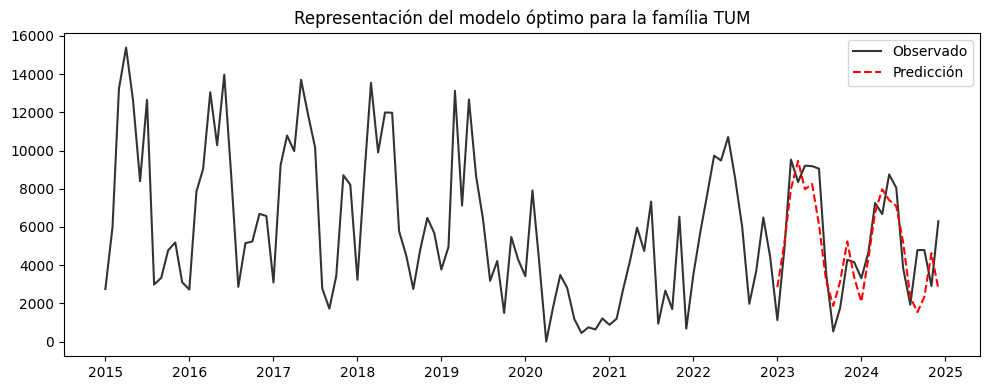

In [44]:
#=== 14) Cálculo de métricas de evaluación del modelo óptimo ===

# Gráfico evaluación modelo óptimo
plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(valores_predicciones_optimas.index, valores_predicciones_optimas, "--", label="Predicción", color="red")
plt.title("Representación del modelo óptimo para la família TUM")
plt.legend(); plt.tight_layout(); plt.show()

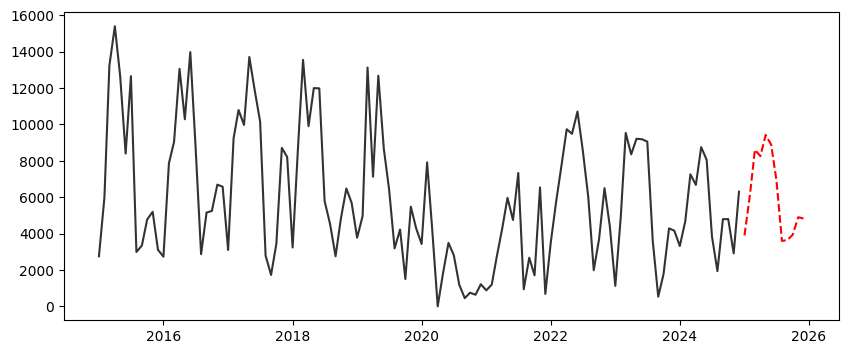

In [45]:
# === 15) Predicciones futuras a 12 meses ===

# Predicciones futuras a 12 meses
pred_fut = res.get_forecast(steps=12) # Predicciones a 12 meses
predicciones_futuras = pred_fut.predicted_mean # Valores predichos

# Graficar la predicción
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label="Observado", color="black", alpha=0.8)
plt.plot(predicciones_futuras.index, predicciones_futuras, "--", label="Forecast +12m", color="red")

In [46]:
# === 16) Serie de residuos completa para SARIMA (train + test) ===

# Crear un DataFrame para almacenar los residuos completos
df_resid_full = pd.DataFrame({
    "y": y_masked.astype(float)
})

df_resid_full["yhat_sarima"] = np.nan # Inicializar la columna de predicciones con NaN
df_resid_full.loc[y_train.index, "yhat_sarima"] = modelo_optimo_entrenado.fittedvalues # Asignar las predicciones del entrenamiento
df_resid_full.loc[y_test.index, "yhat_sarima"] = valores_predicciones_optimas # Asignar las predicciones del test
df_resid_full["resid"] = df_resid_full["y"] - df_resid_full["yhat_sarima"] # Calcular los residuos
df_resid_full = df_resid_full.dropna(subset=["resid"]) # Eliminar filas con NaN en la columna de residuos
print("Tamaño df_resid_full:", df_resid_full.shape) # Imprimir el tamaño del DataFrame de residuos
print(df_resid_full.head()) # Mostrar las primeras filas del DataFrame de residuos

Tamaño df_resid_full: (98, 3)
                  y   yhat_sarima        resid
date                                          
2015-01-01   2747.0   1790.908446   956.091554
2015-02-01   5980.0   1205.412915  4774.587085
2015-03-01  13228.0   8957.374133  4270.625867
2015-04-01  15390.0   6766.349220  8623.650780
2015-05-01  12656.0  12023.962361   632.037639


In [47]:
# === 17) Escalado de residuos y creación de secuencias para LSTM ===

# Escalado de residuos para LSTM
# Se escala la columna de residuos para que el LSTM pueda trabajar con datos normalizados
scaler_resid = StandardScaler()
resid_scaled = scaler_resid.fit_transform(
    df_resid_full[["resid"]]
).flatten()  

# Vector 1D de residuos escalados
# Definición de la función para crear secuencias de datos para LSTM
def create_sequences(series, n_lags=12):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i])  # ventana de residuos pasados
        y.append(series[i])           # residuo en t
    return np.array(X), np.array(y)

N_LAGS = 12  # nº de rezagos que verá el LSTM


X_all_scaled, y_all_scaled = create_sequences(resid_scaled, n_lags=N_LAGS) # Secuencias sobre residuos ESCALADOS


target_index = df_resid_full.index[N_LAGS:] # Índices temporales asociados a cada target (posición i de df_resid_full)


is_test = target_index.isin(y_test.index) # Marcamos qué muestras pertenecen al test (mismo criterio que y_test)
# is_test es un booleano que indica si el índice está en el conjunto de test
is_train = ~is_test # is_train es el complemento de is_test, indicando qué muestras son de entrenamiento


X_train_resid = X_all_scaled[is_train] # Secuencias de entrenamiento
X_test_resid  = X_all_scaled[is_test] # Secuencias de test

y_train_resid_scaled = y_all_scaled[is_train] # Valores de residuos escalados para entrenamiento
y_test_resid_scaled  = y_all_scaled[is_test] # Valores de residuos escalados para test


X_train_resid = X_train_resid.reshape((X_train_resid.shape[0], N_LAGS, 1)) # Reshape para LSTM: (n_samples, n_lags, n_features)
X_test_resid  = X_test_resid.reshape((X_test_resid.shape[0],  N_LAGS, 1)) # Reshape para LSTM: (n_samples, n_lags, n_features)

# print("Shapes X_train, X_test:", X_train_resid.shape, X_test_resid.shape) # Imprimir las formas de los conjuntos de entrenamiento y test

In [48]:
# === 18) Entrenamiento del modelo LSTM sobre residuos ===

model_resid = Sequential() # Modelo LSTM para residuos
model_resid.add(LSTM(64, input_shape=(N_LAGS, 1), return_sequences=True)) # Capa LSTM con 64 unidades y secuencias de salida
model_resid.add(LSTM(32)) # Capa LSTM con 32 unidades
model_resid.add(Dense(1)) # Capa de salida densa para la predicción de residuos

model_resid.compile(optimizer="adam", loss="mse") # Compilación del modelo LSTM

# Entrenamiento del modelo LSTM sobre residuos
# Se usa EarlyStopping para evitar el sobreajuste   
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Entrenamiento del modelo LSTM sobre residuos
# Se entrena el modelo LSTM con los datos de entrenamiento de residuos escalados
history = model_resid.fit(
    X_train_resid, y_train_resid_scaled,
    validation_split=0.2,
    epochs=300,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)

# Gráfico de la pérdida del modelo LSTM
# plt.figure(figsize=(6,3))
# plt.plot(history.history["loss"], label="train")
# plt.plot(history.history["val_loss"], label="val")
# plt.legend()
# plt.title("Loss LSTM residuos SARIMA")
# plt.tight_layout()
# plt.show()


In [49]:
# === 19) Predicción de residuos en test (escala original) ===


y_resid_hat_test_scaled = model_resid.predict(X_test_resid).flatten() # Predicciones de residuos en test (escalados)

# Inversión del escalado de residuos para obtener los valores originales
# Se invierte el escalado de los residuos para obtener los valores originales
y_resid_hat_test = scaler_resid.inverse_transform(
    y_resid_hat_test_scaled.reshape(-1, 1)
).flatten()

# Impresión de los primeros residuos reales y predichos en test (en escala original)
y_resid_true_test = scaler_resid.inverse_transform(
    y_test_resid_scaled.reshape(-1, 1)
).flatten()

idxs_test_resid = target_index[is_test] # Índices temporales asociados a los residuos de test

# print("Primeros residuos reales de test (ORIGINALES):")
# print(np.round(y_resid_true_test[:10], 2))

# print("\nPrimeros residuos predichos por el LSTM (ORIGINALES):")
# print(np.round(y_resid_hat_test[:10], 2))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [50]:
# === 20) Evaluación del modelo híbrido SARIMA + LSTM ===

y_true_hybrid   = df_resid_full.loc(idxs_test_resid)["y"].values if False else df_resid_full.loc[idxs_test_resid, "y"].values # Valores reales de test (en escala original)
y_sarima_test   = df_resid_full.loc[idxs_test_resid, "yhat_sarima"].values # Predicciones del modelo SARIMA en test (en escala original)
y_pred_hybrid   = y_sarima_test + y_resid_hat_test # Predicciones del modelo híbrido SARIMA + LSTM (en escala original)

# Cálculo de métricas de evaluación del modelo híbrido
# Se calculan las métricas de evaluación del modelo híbrido SARIMA + LSTM
print("\n=== SARIMA solo (mismas fechas que el LSTM) ===")
metrics_sarima = metricas(y_true_hybrid, y_sarima_test, eps_mape=1.0)
for k, v in metrics_sarima.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")

# Evaluación del modelo híbrido SARIMA + LSTM
# Se calculan las métricas de evaluación del modelo híbrido SARIMA + LSTM
print("\n=== Híbrido SARIMA + LSTM(residuos) ===")
metrics_hybrid = metricas(y_true_hybrid, y_pred_hybrid, eps_mape=1.0)
for k, v in metrics_hybrid.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")


=== SARIMA solo (mismas fechas que el LSTM) ===
R2: 0.65
RMSLE: 0.51
RMSE: 1,625.66
MAE: 1,374.51
MAPE_safe(%): 42.40%
SMAPE(%): 35.76%
WAPE(%): 25.58%

=== Híbrido SARIMA + LSTM(residuos) ===
R2: 0.65
RMSLE: 0.51
RMSE: 1,616.57
MAE: 1,370.35
MAPE_safe(%): 43.00%
SMAPE(%): 35.61%
WAPE(%): 25.51%


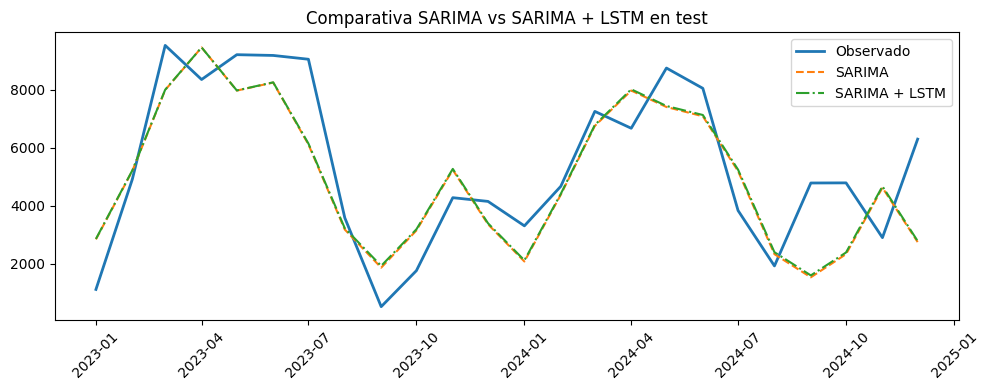

In [51]:
# === 21) Gráfico comparando SARIMA vs Híbrido en test ===

fechas_test_lstm = idxs_test_resid # Fechas de test para el LSTM (índices temporales asociados a los residuos de test)


# Gráfico comparativo de las predicciones del modelo SARIMA y el modelo híbrido SARIMA + LSTM
# Se grafican las predicciones del modelo SARIMA y el modelo híbrido SARIMA
plt.figure(figsize=(10,4))
plt.plot(fechas_test_lstm, y_true_hybrid, label="Observado", linewidth=2)
plt.plot(fechas_test_lstm, y_sarima_test, label="SARIMA", linestyle="--")
plt.plot(fechas_test_lstm, y_pred_hybrid, label="SARIMA + LSTM", linestyle="-.")
plt.xticks(rotation=45)
plt.title("Comparativa SARIMA vs SARIMA + LSTM en test")
plt.legend()
plt.tight_layout()
plt.show()
